# 简述
通过广义帕累托模型，在额外处理极高值的情况下，对于主体部分可以直接成功拟合。适用于大多数空间转录组模型，经过测试也适用于单细胞转录组。
限制：对于数据的预处理有要求，需要过滤掉表达值过低的基因，否则太多的极低值会影响拟合效果。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import scipy.sparse as sp
from scipy.stats import genpareto, ks_2samp

In [2]:
def calc_zero_proportion(X):
    return np.mean(X == 0, axis=0)

In [3]:
def evaluate_fit(original, generated, quantiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    def cohens_d(x1, x2):
        n1, n2 = len(x1), len(x2)
        var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_se

    def relative_error(x1, x2):
        return np.abs(np.mean(x1) - np.mean(x2)) / np.mean(x1)

    # 计算主要指标
    effect_size = cohens_d(original, generated)
    rel_error = relative_error(original, generated)
    ks_stat, _ = ks_2samp(original, generated)
    correlation = np.corrcoef(np.sort(original), np.sort(generated))[0, 1]

    # 计算分位数相对误差
    orig_quant = np.quantile(original, quantiles)
    gen_quant = np.quantile(generated, quantiles)
    quant_rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

    # 评估结果
    results = {
        "Cohen's d": effect_size,
        "Relative Error": rel_error,
        "KS Statistic": ks_stat,
        "Correlation": correlation,
        "Quantile Relative Errors": dict(zip([f"{q*100}th" for q in quantiles], quant_rel_errors))
    }

    # 修改判定标准
    excellent = (abs(effect_size) < 0.05 and rel_error < 0.05 and ks_stat < 0.1 and correlation > 0.95
                )

    good = (abs(effect_size) < 0.1 and rel_error < 0.15 and ks_stat < 0.15 and correlation > 0.9 
            )

    fair = (abs(effect_size) < 0.2 and rel_error < 0.2 and ks_stat < 0.2 and correlation > 0.8 
            )
    if excellent:
        verdict = "Excellent fit"
    elif good:
        verdict = "Good fit"
    elif fair:
        verdict = "Fair fit"
    else:
        verdict = "Poor fit"

    results["Verdict"] = verdict

    return results

In [4]:
def evaluate_plot(original, generated, quantiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    def cohens_d(x1, x2):
        n1, n2 = len(x1), len(x2)
        var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_se

    def relative_error(x1, x2):
        return np.abs(np.mean(x1) - np.mean(x2)) / np.mean(x1)

    # 计算主要指标
    effect_size = cohens_d(original, generated)
    rel_error = relative_error(original, generated)
    ks_stat, _ = ks_2samp(original, generated)
    correlation = np.corrcoef(np.sort(original), np.sort(generated))[0, 1]

    # 计算分位数相对误差
    orig_quant = np.quantile(original, quantiles)
    gen_quant = np.quantile(generated, quantiles)
    quant_rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

    # 评估结果
    results = {
        "Cohen's d": effect_size,
        "Relative Error": rel_error,
        "KS Statistic": ks_stat,
        "Correlation": correlation,
        "Quantile Relative Errors": dict(zip([f"{q*100}th" for q in quantiles], quant_rel_errors))
    }

    # 修改判定标准
    excellent = (abs(effect_size) < 0.05 and rel_error < 0.05 and ks_stat < 0.1 and correlation > 0.95
                )

    good = (abs(effect_size) < 0.1 and rel_error < 0.15 and ks_stat < 0.15 and correlation > 0.9 
            )

    fair = (abs(effect_size) < 0.2 and rel_error < 0.2 and ks_stat < 0.2 and correlation > 0.8 
            )



    if excellent:
        verdict = "Excellent fit"
    elif good:
        verdict = "Good fit"
    elif fair:
        verdict = "Fair fit"
    else:
        verdict = "Poor fit"

    results["Verdict"] = verdict


    plt.figure(figsize=(15, 5))

    # 密度图比较
    plt.subplot(131)
    kde_orig = gaussian_kde(np.log1p(original))
    kde_gen = gaussian_kde(np.log1p(generated))
    x_range = np.linspace(np.min(np.log1p(original)), np.max(np.log1p(original)), 1000)
    plt.plot(x_range, kde_orig(x_range), label='Original')
    plt.plot(x_range, kde_gen(x_range), label='Generated')
    plt.title('Density Comparison (Log Scale)')
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('Density')
    plt.legend()

    # Q-Q图（对数刻度）
    plt.subplot(132)
    plt.scatter(np.log1p(np.sort(original)), np.log1p(np.sort(generated)), alpha=0.5)
    plt.plot([np.log1p(min(original)), np.log1p(max(original))], 
             [np.log1p(min(original)), np.log1p(max(original))], 'r--')
    plt.xlabel('Original Quantiles (Log Scale)')
    plt.ylabel('Generated Quantiles (Log Scale)')
    plt.title('Q-Q Plot (Log Scale)')

    # ECDF（对数刻度）
    plt.subplot(133)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return x, y
    x_orig, y_orig = ecdf(original)
    x_gen, y_gen = ecdf(generated)
    plt.step(np.log1p(x_orig), y_orig, where='post', label='Original', alpha=0.7)
    plt.step(np.log1p(x_gen), y_gen, where='post', label='Generated', alpha=0.7)
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function (Log Scale)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

In [5]:
def genpareto_fit_var(filtered_adata, mode="strict",threshold=0.99):
    if sp.issparse(filtered_adata.X):
        filtered_adata.X = filtered_adata.X.A

    # 计算基因方差
    gene_vars = np.var(filtered_adata.X, axis=0, ddof=1)  

    if mode == "strict":
        thresholds = [99.5, 99, 98.5, 98, 97.5,97,96,95]
        best_score = float('inf')
        best_threshold = None
        best_samples = None
        best_evaluation = None

        for percentile in thresholds:
            current_threshold = np.percentile(gene_vars, percentile)
            main_data = gene_vars[gene_vars <= current_threshold]
            tail_data = gene_vars[gene_vars > current_threshold]

            # 直接对主体部分进行拟合
            shape, loc, scale = genpareto.fit(main_data)

            n_main = len(main_data)
            n_tail = len(tail_data)


            new_main = genpareto.rvs(shape, loc, scale, size=n_main)
            new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

            new_samples = np.concatenate([new_main, new_tail])
            new_samples = np.clip(new_samples, np.min(gene_vars), np.max(gene_vars))

            # 评估拟合效果
            evaluation = evaluate_fit(gene_vars, new_samples)

            score = (abs(evaluation["Cohen's d"]) + 
                     evaluation["Relative Error"] + 
                     evaluation["KS Statistic"] + 
                     (1 - evaluation["Correlation"]))

            if score < best_score:
                best_score = score
                best_threshold = percentile
                best_samples = new_samples
                best_evaluation = evaluation
        # 打印最后拟合的帕累托模型参数
        print(f"Best threshold: {best_threshold}")
        print(f"Best shape: {shape}")
        print(f"Best loc: {loc}")
        print(f"Best scale: {scale}")
            

        return best_samples, best_threshold, best_evaluation

    else:
        threshold = np.percentile(gene_vars, threshold*100)
        main_data = gene_vars[gene_vars <= threshold]
        tail_data = gene_vars[gene_vars > threshold]


        shape, loc, scale = genpareto.fit(main_data)

        n_main = len(main_data)
        n_tail = len(tail_data)

        new_main = genpareto.rvs(shape, loc, scale, size=n_main)
        new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

        new_samples = np.concatenate([new_main, new_tail])
        new_samples = np.clip(new_samples, np.min(gene_vars), np.max(gene_vars))

        return new_samples


In [6]:
def genpareto_fit_mean(filtered_adata, mode="strict", threshold=None):
    if sp.issparse(filtered_adata.X):
        filtered_adata.X = filtered_adata.X.A

    gene_means = np.mean(filtered_adata.X, axis=0)

    if mode == "strict":
        thresholds = [99.5, 99, 98.5, 98, 97.5, 97]
        best_score = float('inf')
        best_threshold = None
        best_samples = None
        best_evaluation = None

        for percentile in thresholds:
            current_threshold = np.percentile(gene_means, percentile)
            main_data = gene_means[gene_means <= current_threshold]
            tail_data = gene_means[gene_means > current_threshold]

            shape, loc, scale = genpareto.fit(main_data)

            n_main = len(main_data)
            n_tail = len(tail_data)

            new_main = genpareto.rvs(shape, loc, scale, size=n_main)
            new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

            new_samples = np.concatenate([new_main, new_tail])
            new_samples = np.clip(new_samples, np.min(gene_means), np.max(gene_means))

            # 评估拟合效果
            evaluation = evaluate_fit(gene_means, new_samples)
            
            score = (abs(evaluation["Cohen's d"]) + 
                     evaluation["Relative Error"] + 
                     evaluation["KS Statistic"] + 
                     (1 - evaluation["Correlation"]))

            if score < best_score:
                best_score = score
                best_threshold = percentile
                best_samples = new_samples
                best_evaluation = evaluation

        return best_samples, best_threshold, best_evaluation

    else:
        threshold = np.percentile(gene_means, 99)
        main_data = gene_means[gene_means <= threshold]
        tail_data = gene_means[gene_means > threshold]

        shape, loc, scale = genpareto.fit(main_data)

        n_main = len(main_data)
        n_tail = len(tail_data)

        new_main = genpareto.rvs(shape, loc, scale, size=n_main)
        new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

        new_samples = np.concatenate([new_main, new_tail])
        new_samples = np.clip(new_samples, np.min(gene_means), np.max(gene_means))

        return new_samples
    


In [7]:
def genpareto_fit_zero_p(filtered_adata, mode="strict", threshold=0.99):
    if sp.issparse(filtered_adata.X):
        filtered_adata.X = filtered_adata.X.A

    zero_proportion = calc_zero_proportion(filtered_adata.X)
    zero_proportion = 1- zero_proportion

    def transform_data(data, epsilon=1e-10):
        return -np.log(1 - np.clip(data, 0, 1-epsilon))

    def inverse_transform(data):
        return 1 - np.exp(-data)

    def fit_and_sample(data, n_samples):
        transformed_data = transform_data(data)
        shape, loc, scale = genpareto.fit(transformed_data)
        samples = genpareto.rvs(shape, loc, scale, size=n_samples)
        return inverse_transform(samples)

    def evaluate_fit(original, new):
        ks_stat, _ = ks_2samp(original, new)
        return {
            "KS Statistic": ks_stat,
            "Mean Difference": np.mean(original) - np.mean(new),
            "Std Difference": np.std(original) - np.std(new),
            "Correlation": np.corrcoef(original, new)[0, 1]
        }

    if mode == "strict":
        thresholds = [0.995, 0.99, 0.985, 0.98, 0.975]
        best_score = float('inf')
        best_threshold = None
        best_samples = None
        best_evaluation = None

        for percentile in thresholds:
            threshold = np.percentile(zero_proportion, percentile * 100)
            main_data = zero_proportion[zero_proportion <= threshold]
            tail_data = zero_proportion[zero_proportion > threshold]

            n_main = len(main_data)
            n_tail = len(tail_data)

            new_main = fit_and_sample(main_data, n_main)
            new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

            new_samples = np.concatenate([new_main, new_tail])
            new_samples = np.clip(new_samples, 0, 1)

            evaluation = evaluate_fit(zero_proportion, new_samples)

            score = (abs(evaluation["Mean Difference"]) + 
                     abs(evaluation["Std Difference"]) + 
                     evaluation["KS Statistic"] + 
                     (1 - evaluation["Correlation"]))

            if score < best_score:
                best_score = score
                best_threshold = percentile
                best_samples = new_samples
                best_evaluation = evaluation

        return 1-best_samples, best_threshold, best_evaluation

    else:
        threshold = np.percentile(zero_proportion, threshold * 100)
        main_data = zero_proportion[zero_proportion <= threshold]
        tail_data = zero_proportion[zero_proportion > threshold]

        n_main = len(main_data)
        n_tail = len(tail_data)

        new_main = fit_and_sample(main_data, n_main)
        new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

        new_samples = np.concatenate([new_main, new_tail])
        new_samples = np.clip(new_samples, 0, 1)

        return 1-new_samples



In [8]:
def test_fit(adata):

    new_var, var_threshold, var_evaluation = genpareto_fit_var(adata, mode="strict")
    print("Variance Fit:")
    print(f"Threshold: {var_threshold}")
    print(var_evaluation)

    new_mean, mean_threshold, mean_evaluation = genpareto_fit_mean(adata, mode="strict")
    print("\nMean Fit:")
    print(f"Threshold: {mean_threshold}")
    print(mean_evaluation)

    new_zero_p,threshold,zero_evaluation = genpareto_fit_zero_p(adata)
    print("\nZero Proportion Fit:")
    zero_p_evaluation = evaluate_fit(calc_zero_proportion(adata.X), new_zero_p)
    print(zero_p_evaluation)

    print("\nVariance Fit:")
    evaluate_plot(np.var(adata.X, axis=0, ddof=1), new_var)

    print("\nMean Fit:")
    evaluate_plot(np.mean(adata.X, axis=0), new_mean)

    print("\nZero Proportion Fit:")
    evaluate_plot(calc_zero_proportion(adata.X), new_zero_p)


## 测试Visium 
测试三个样本，均是极好fit

Best threshold: 99.5
Best shape: 0.21467341934344497
Best loc: 0.02182294946660513
Best scale: 0.15627563747007922
Variance Fit:
Threshold: 99.5
{"Cohen's d": 0.0016353641155904082, 'Relative Error': 0.04487317585431392, 'KS Statistic': 0.05093709408053442, 'Correlation': 0.9882731541356773, 'Quantile Relative Errors': {'25.0th': 0.0065105229459132136, '50.0th': 0.09812102093797637, '75.0th': 0.17888536425798876, '90.0th': 0.13270324152992383, '95.0th': 0.0043568741325443775, '99.0th': 0.004540785062706321}, 'Verdict': 'Excellent fit'}

Mean Fit:
Threshold: 97.5
{"Cohen's d": -0.00174724496190654, 'Relative Error': 0.011818843949560329, 'KS Statistic': 0.06299870105771016, 'Correlation': 0.9928261172353244, 'Quantile Relative Errors': {'25.0th': 0.006576294472195505, '50.0th': 0.05073915696162779, '75.0th': 0.03462231676039215, '90.0th': 0.05978009922169682, '95.0th': 0.11535968315634472, '99.0th': 0.032888632007191825}, 'Verdict': 'Excellent fit'}

Zero Proportion Fit:
{"Cohen's d": 0

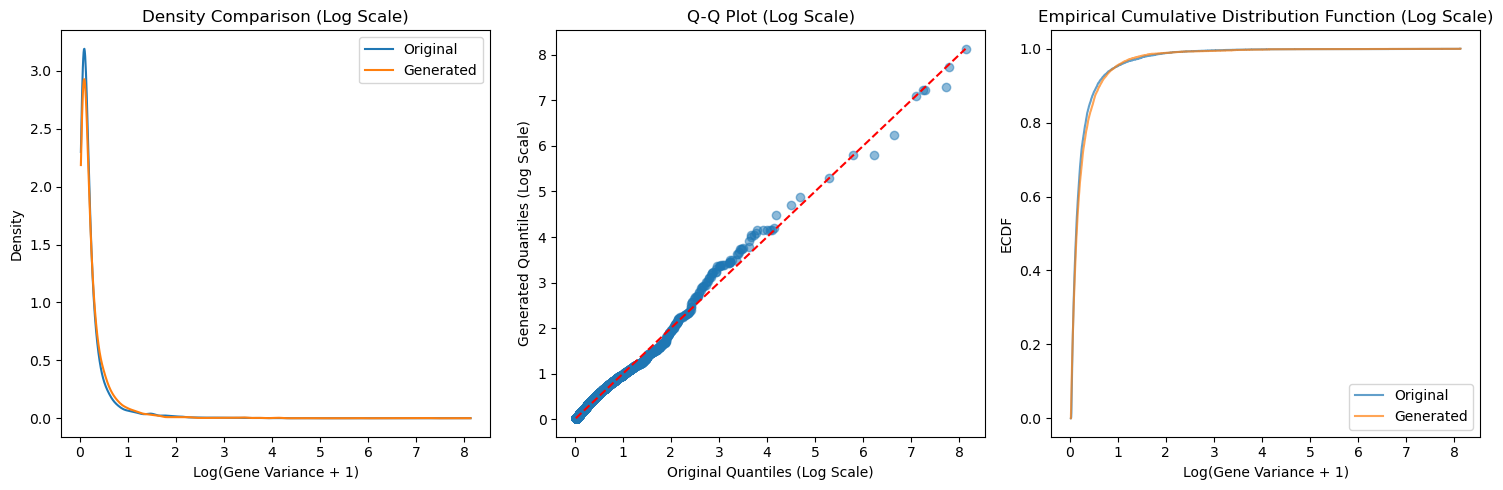


Mean Fit:


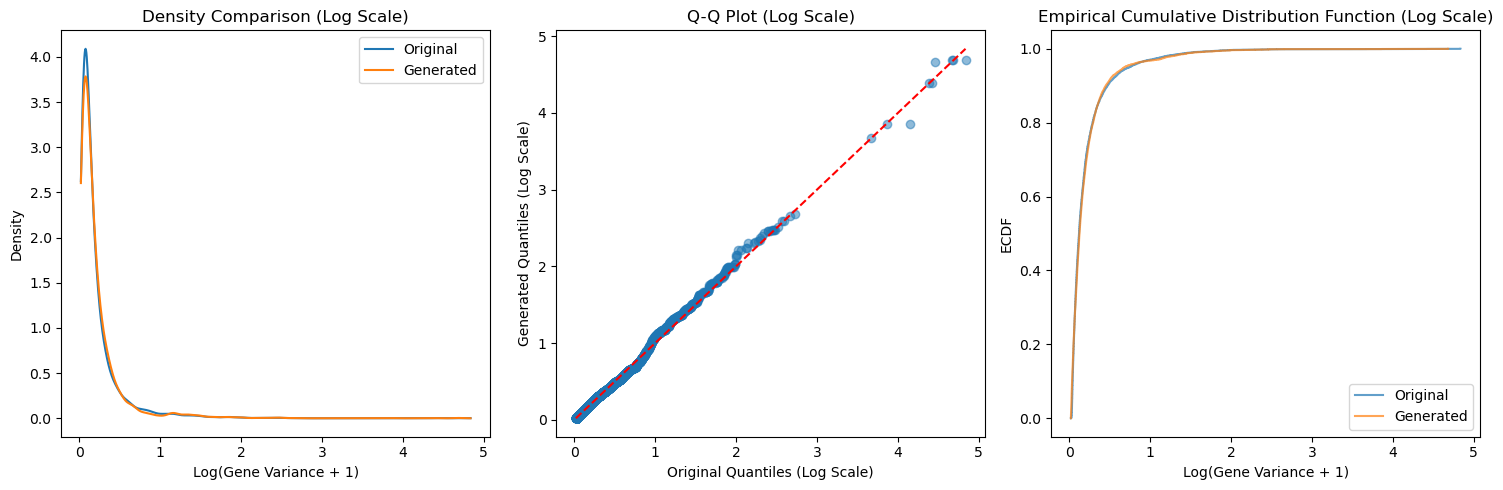


Zero Proportion Fit:


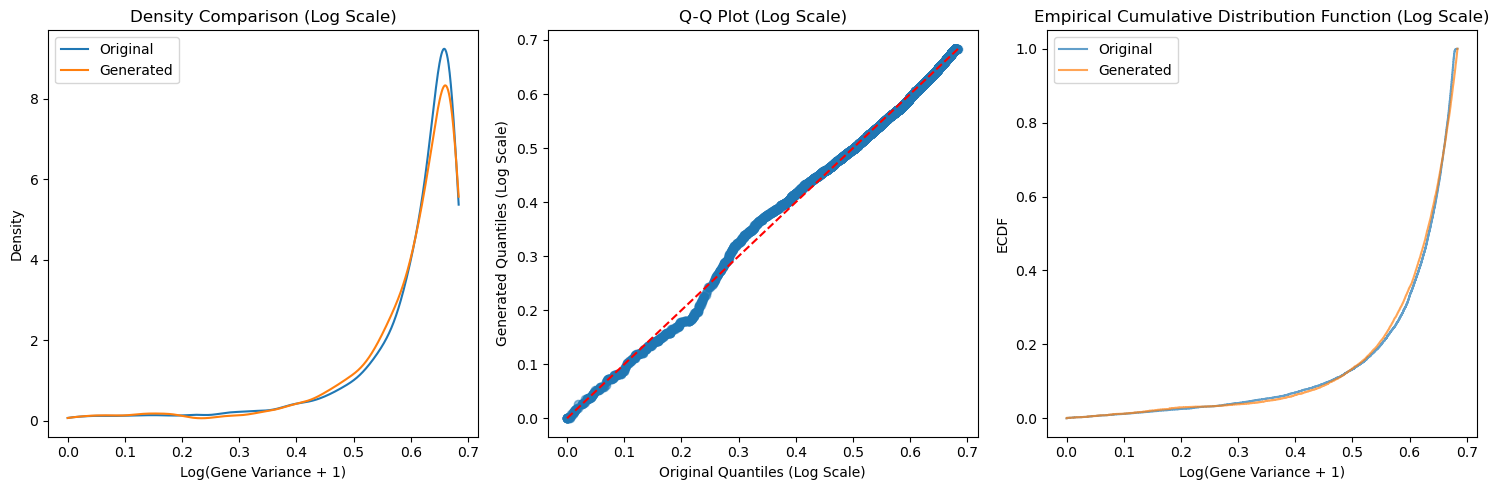

In [11]:
visium_adata1 = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")
test_fit(visium_adata1)

Best threshold: 97.5
Best shape: 0.36018631564134507
Best loc: 0.01101787931284039
Best scale: 0.11968467027058383
Variance Fit:
Threshold: 97.5
{"Cohen's d": -1.220000324270994e-05, 'Relative Error': 0.0003738372759240364, 'KS Statistic': 0.09182425439834416, 'Correlation': 0.9599679026555626, 'Quantile Relative Errors': {'25.0th': 0.06010140942508969, '50.0th': 0.06327998420177836, '75.0th': 0.10466077528778447, '90.0th': 0.0019074250623362142, '95.0th': 0.12436135016894756, '99.0th': 0.04165305714701511}, 'Verdict': 'Excellent fit'}

Mean Fit:
Threshold: 98.5
{"Cohen's d": -0.0011085421639065078, 'Relative Error': 0.007547364559637801, 'KS Statistic': 0.09681061247530343, 'Correlation': 0.993549922208984, 'Quantile Relative Errors': {'25.0th': 0.10418782785494439, '50.0th': 0.06414376326870856, '75.0th': 0.10275330530939769, '90.0th': 0.00013169505664857806, '95.0th': 0.11717440104616683, '99.0th': 0.09568768946620944}, 'Verdict': 'Excellent fit'}

Zero Proportion Fit:
{"Cohen's d":

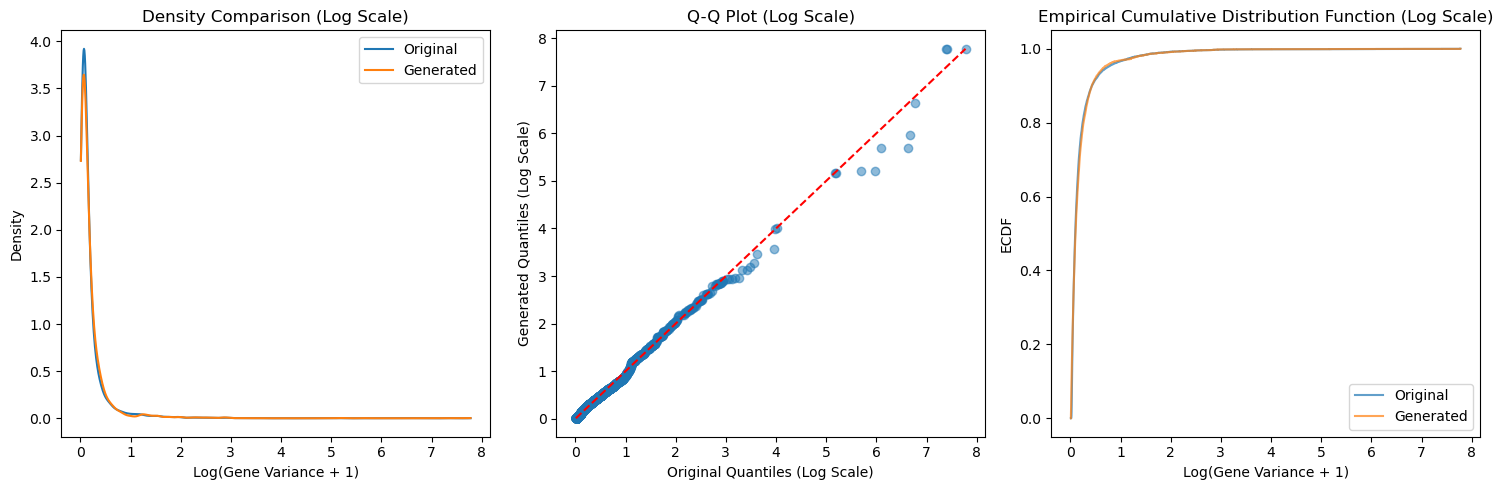


Mean Fit:


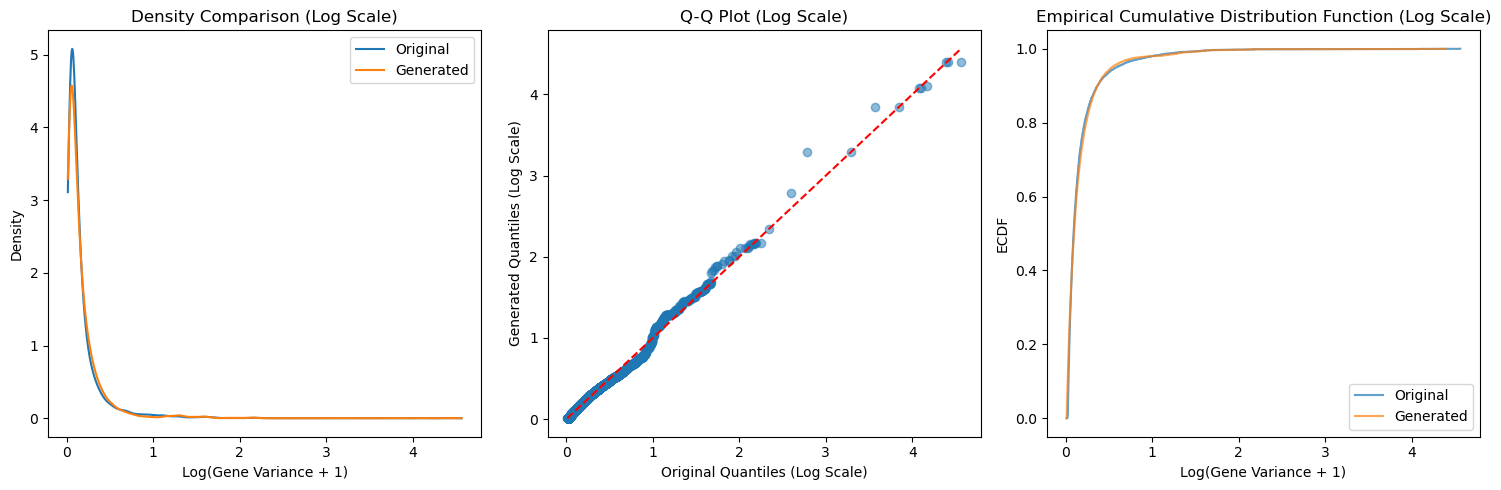


Zero Proportion Fit:


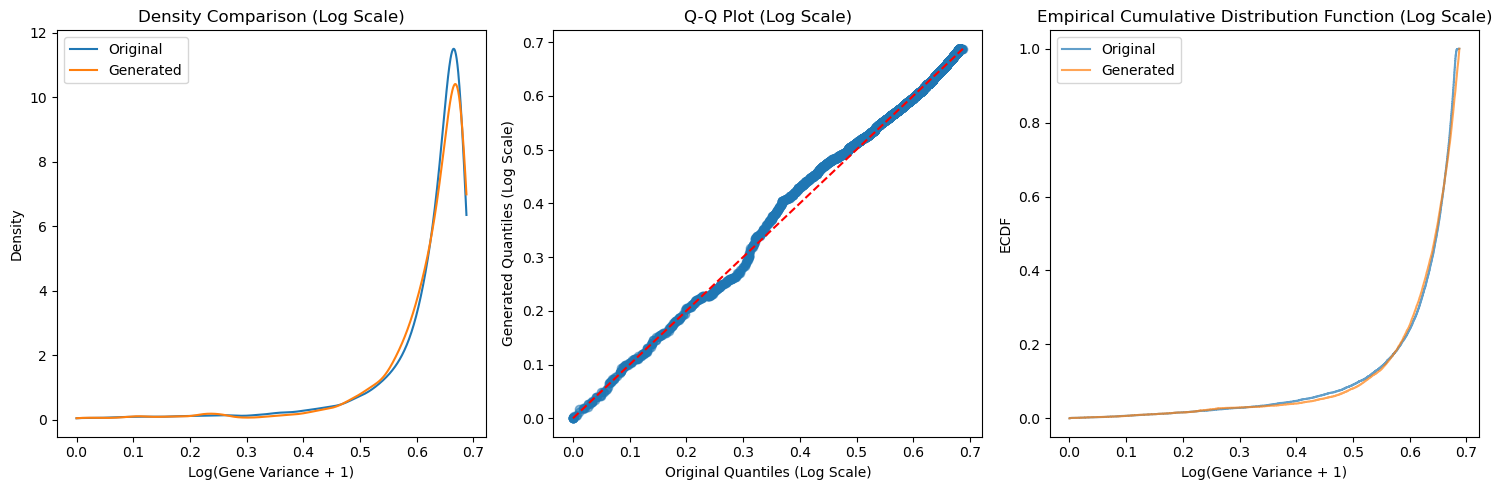

In [59]:
visium_adata2 = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151675.h5ad")
test_fit(visium_adata2)

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


before_filtered:AnnData object with n_obs × n_vars = 3553 × 16572
    obs: 'Ground Truth', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    obsm: 'spatial'
after_filtered:AnnData object with n_obs × n_vars = 3553 × 13072
    obs: 'Ground Truth', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    obsm: 'spatial'
Best threshold: 98
Best shape: 0.9082482679322139
Best loc: 0.013878698933729228
Best scale: 0.09645536926265752
Variance Fit:
Threshold: 98
{"Cohen's d": -0.00020060626859333592, 'Relative Error': 0.006397622896970036, 'KS Statistic': 0.021802325581395332, 'Correlation': 0.9591552158913866, 'Quantile Relative Errors': {'25.0th': 0.07942507788983152, '50.0th': 0.004860269846516438, '75.0th': 0.0012115888479110957, '90.0th': 0.032836471386646526, '95.0th': 0.05061016973209326, '99.0th': 0.12194375200100373}, 'Verdict': 'Excellent fit'}

Mean Fit:
Threshold: 98
{"Cohen's d": -0.0019044255845944726, 'Relative Error': 0.01287669939701676

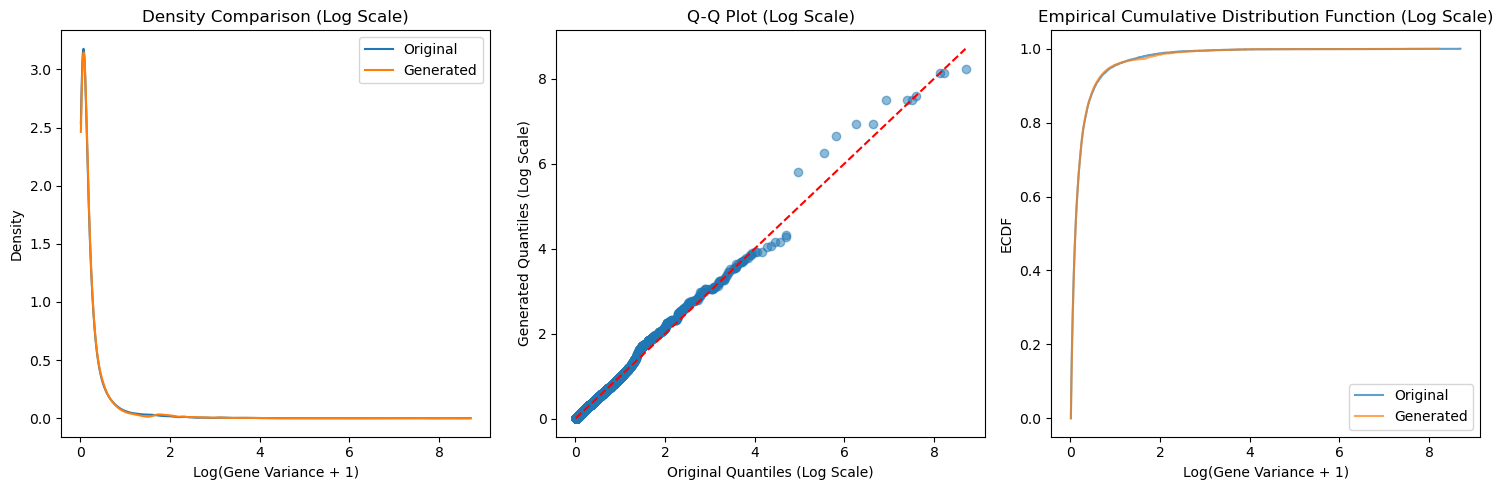


Mean Fit:


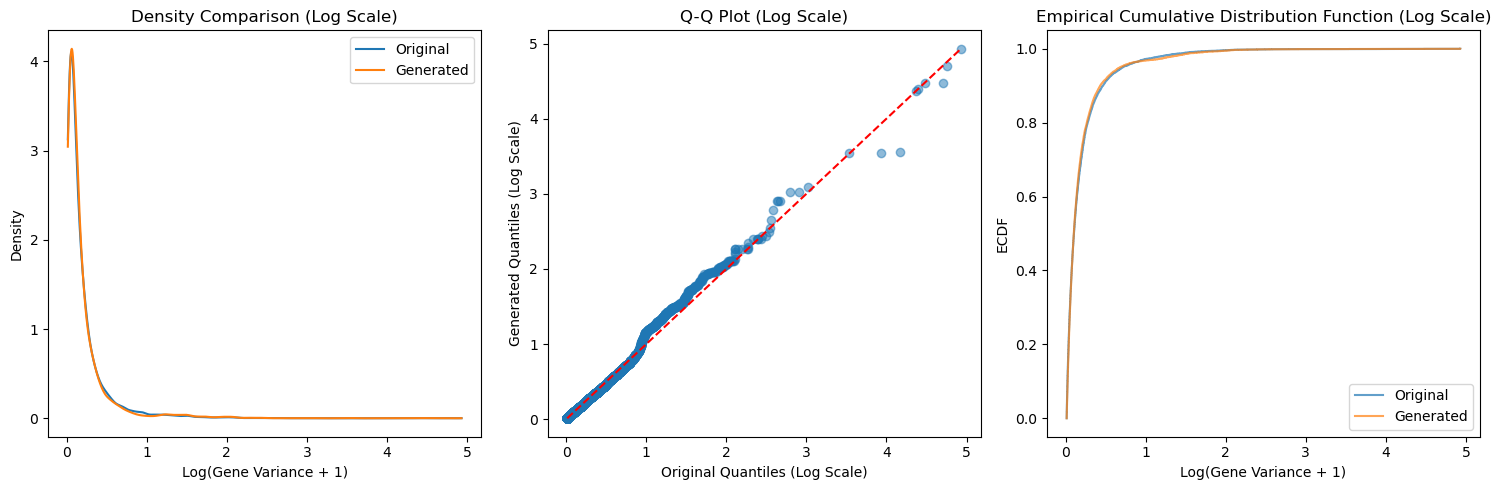


Zero Proportion Fit:


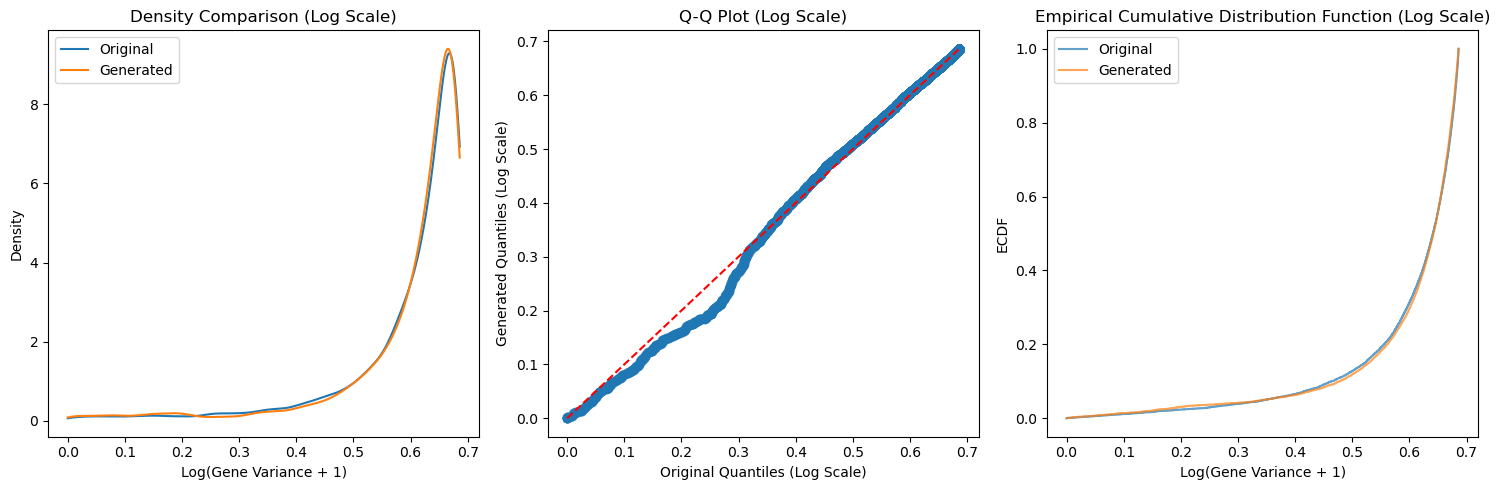

In [63]:
visium_adata3 = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/processed_151673_filtered.h5ad")
print(f"before_filtered:{visium_adata3}")
sc.pp.filter_genes(visium_adata3, min_cells=50)
print(f"after_filtered:{visium_adata3}")
test_fit(visium_adata3)

# 测试其他空转数据
以slide-V2为例。还测试了Xenium和Visium HD，以及Stereo-seq,均通过。因为Slide-V2是这其中效果最差的，所以拿来展示。但是mean和variance的拟合基本都达到了Fair fit，zero proportion 拟合效果不太行。和基因数量少有关。 

before_filtered:AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'
after_filtered:AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'barcode', 'x', 'y', 'n_

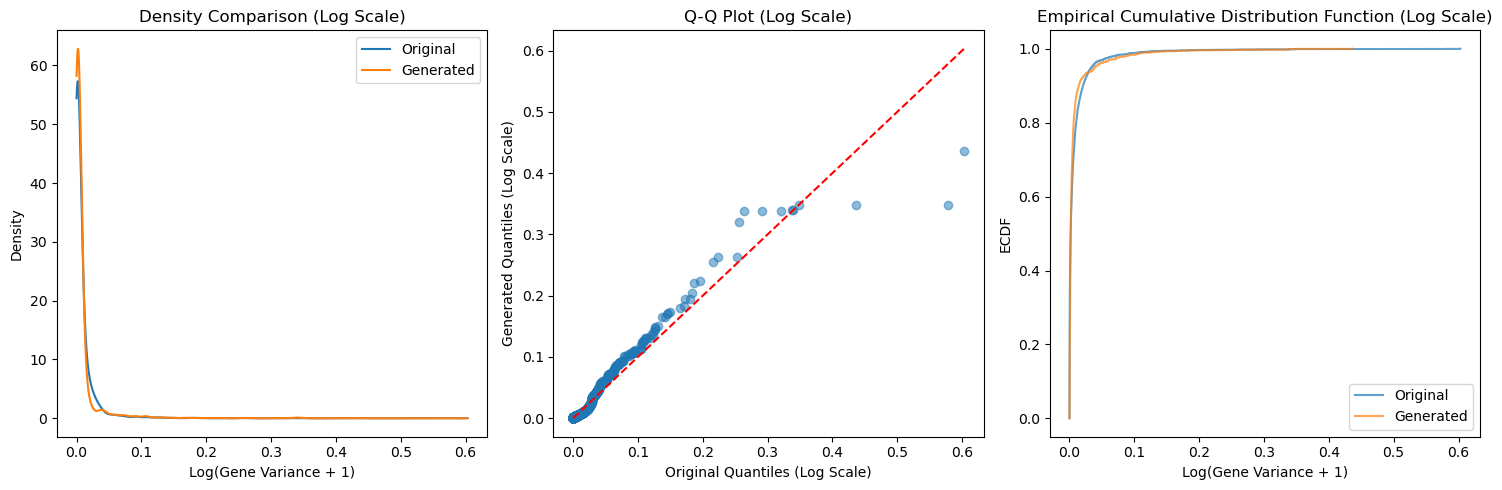


Mean Fit:


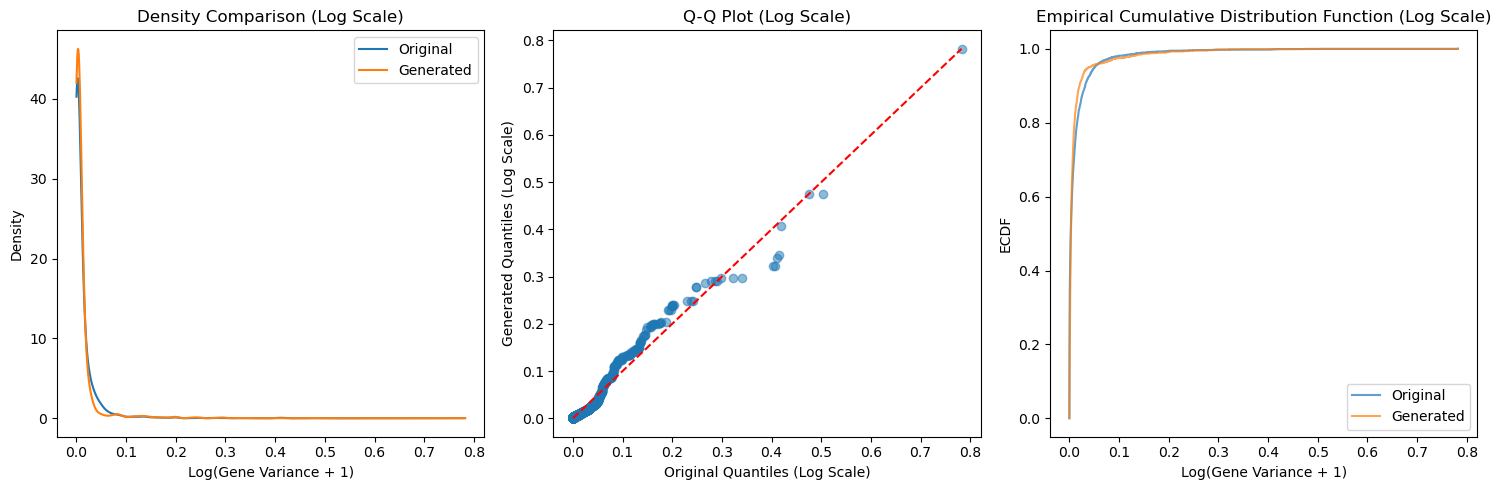


Zero Proportion Fit:


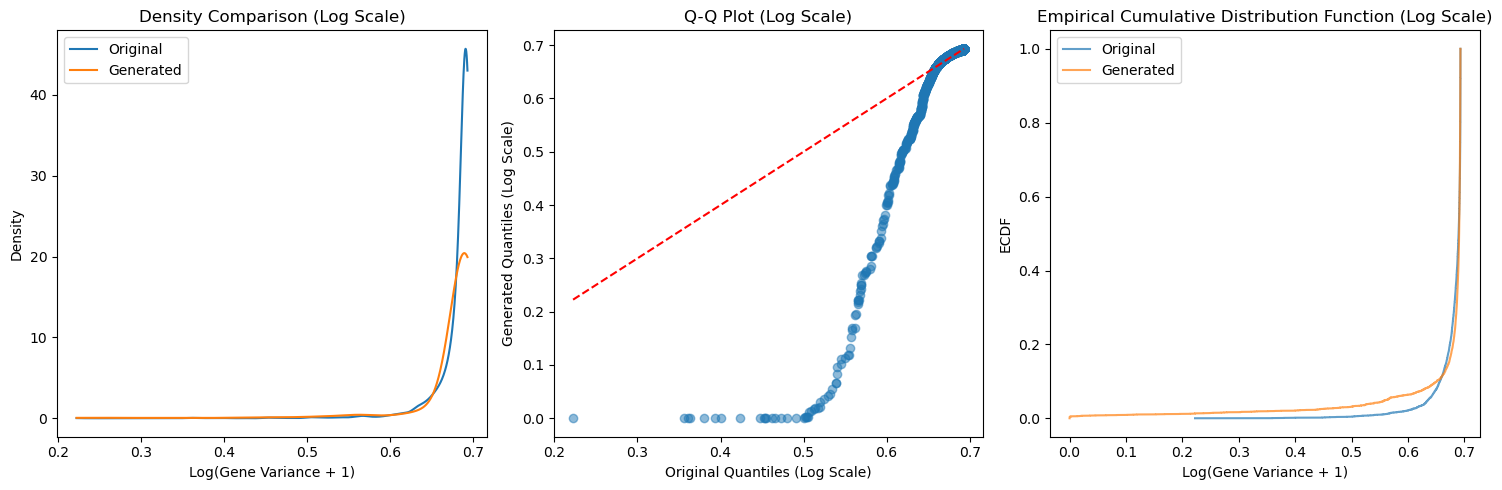

In [12]:
import squidpy as sq
slide_data = sq.datasets.slideseqv2()
print(f"before_filtered:{slide_data}")
sc.pp.filter_genes(slide_data, min_cells=10)
print(f"after_filtered:{slide_data}")
test_fit(slide_data)

## 单细胞RNA测序数据
测试最主流的10x Visium 平台，通过

In [13]:
adata = sc.read_10x_mtx(
    "/Users/chen_yiru/Desktop/simulation/data/filtered_gene_bc_matrices/hg19/", 
    var_names="gene_symbols", 
    cache=True, 
)

In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Best threshold: 97.5
Best shape: 1.026138849729036
Best loc: 0.0034025005080271014
Best scale: 0.03144970728384906
Variance Fit:
Threshold: 97.5
{"Cohen's d": -0.007221210482194212, 'Relative Error': 0.14744634514333574, 'KS Statistic': 0.05344749887336642, 'Correlation': 0.9785594587288093, 'Quantile Relative Errors': {'25.0th': 0.0822807159251037, '50.0th': 0.07297514394062636, '75.0th': 0.2278584555041064, '90.0th': 0.40711714775084595, '95.0th': 0.11486901745369583, '99.0th': 0.23572361109223808}, 'Verdict': 'Good fit'}

Mean Fit:
Threshold: 97.5
{"Cohen's d": -0.005304570909142383, 'Relative Error': 0.03659950004164823, 'KS Statistic': 0.022442541685443906, 'Correlation': 0.9985487567946926, 'Quantile Relative Errors': {'25.0th': 0.06655193193190818, '50.0th': 0.04429217525848933, '75.0th': 0.04175147987289475, '90.0th': 0.03941652768539923, '95.0th': 0.12197498555393081, '99.0th': 0.023613824952885158}, 'Verdict': 'Excellent fit'}

Zero Proportion Fit:
{"Cohen's d": 0.01153518308

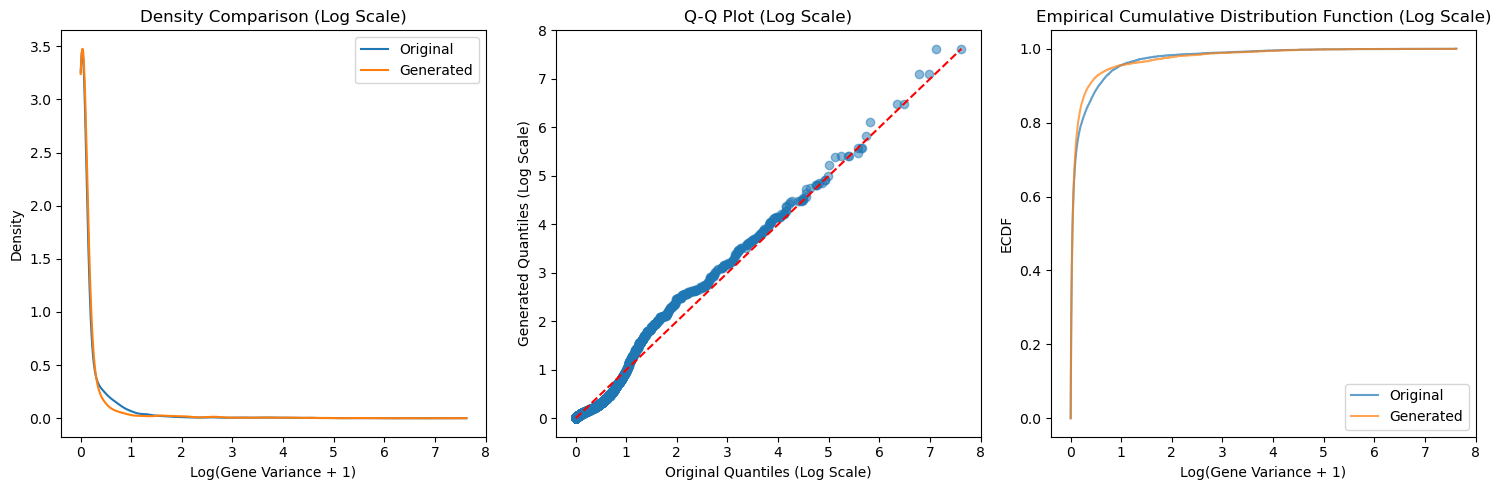


Mean Fit:


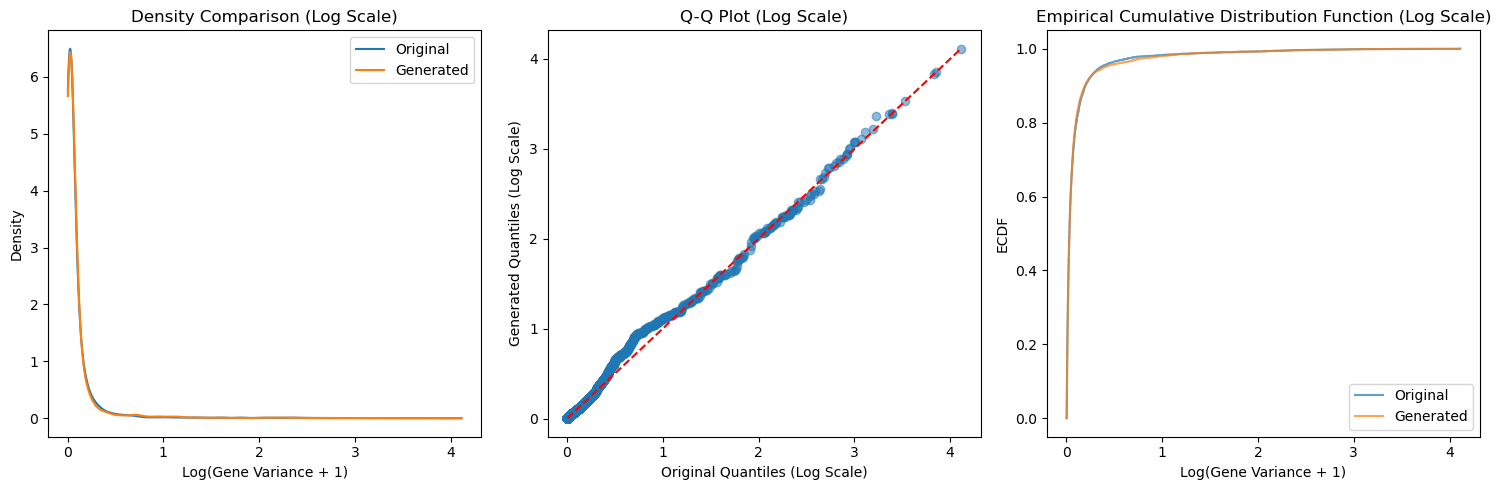


Zero Proportion Fit:


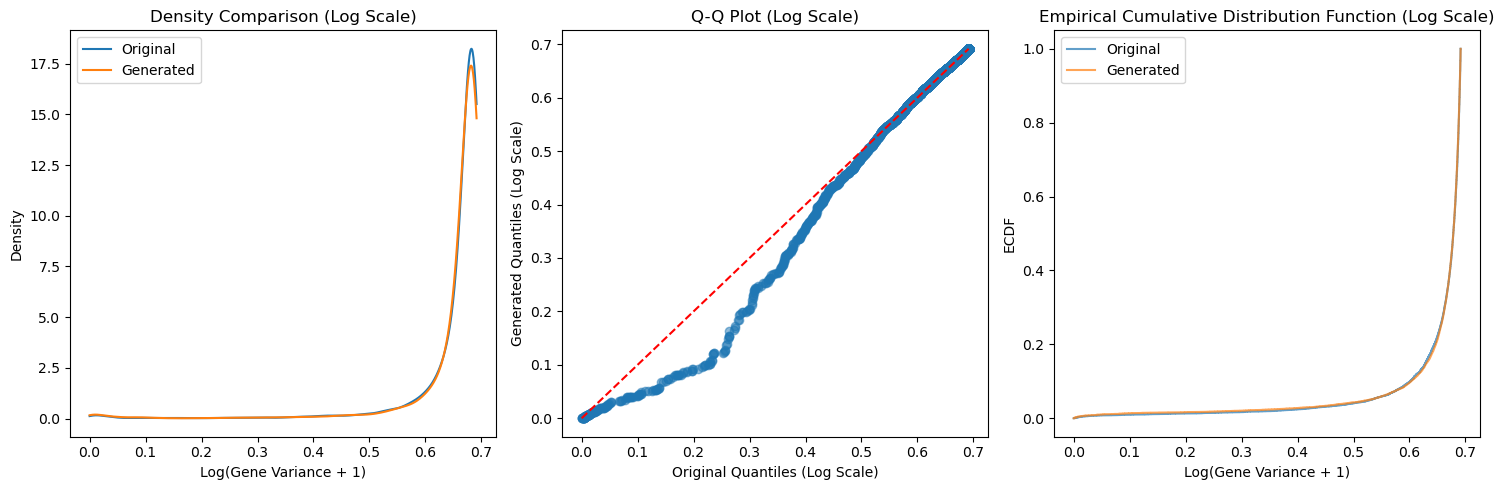

In [18]:
test_fit(adata)